In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from loader import load_models, MODEL_ORDER, MODEL_COLORS

# Only load columns needed for calibration analysis
usecols = ["predicted_win_probability", "is_winner", "turn_progress"]
models = load_models(usecols=usecols)
print(f"\nModels found: {list(models.keys())}")

Loaded naive: 1,875,256 rows
Loaded score: 1,875,256 rows
Loaded baseline: 1,875,256 rows
Loaded xgboost: 1,875,256 rows
Loaded mlp: 1,875,256 rows
Loaded grouped_mlp: 1,875,256 rows
Loaded interaction_mlp: 1,875,256 rows
Loaded attention_mlp: 1,875,256 rows

Models found: ['naive', 'score', 'baseline', 'xgboost', 'mlp', 'grouped_mlp', 'interaction_mlp', 'attention_mlp']


## 1a. Reliability Diagrams
Bins predicted probabilities into deciles and compares predicted vs actual win rate.  
A perfectly calibrated model follows the diagonal.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

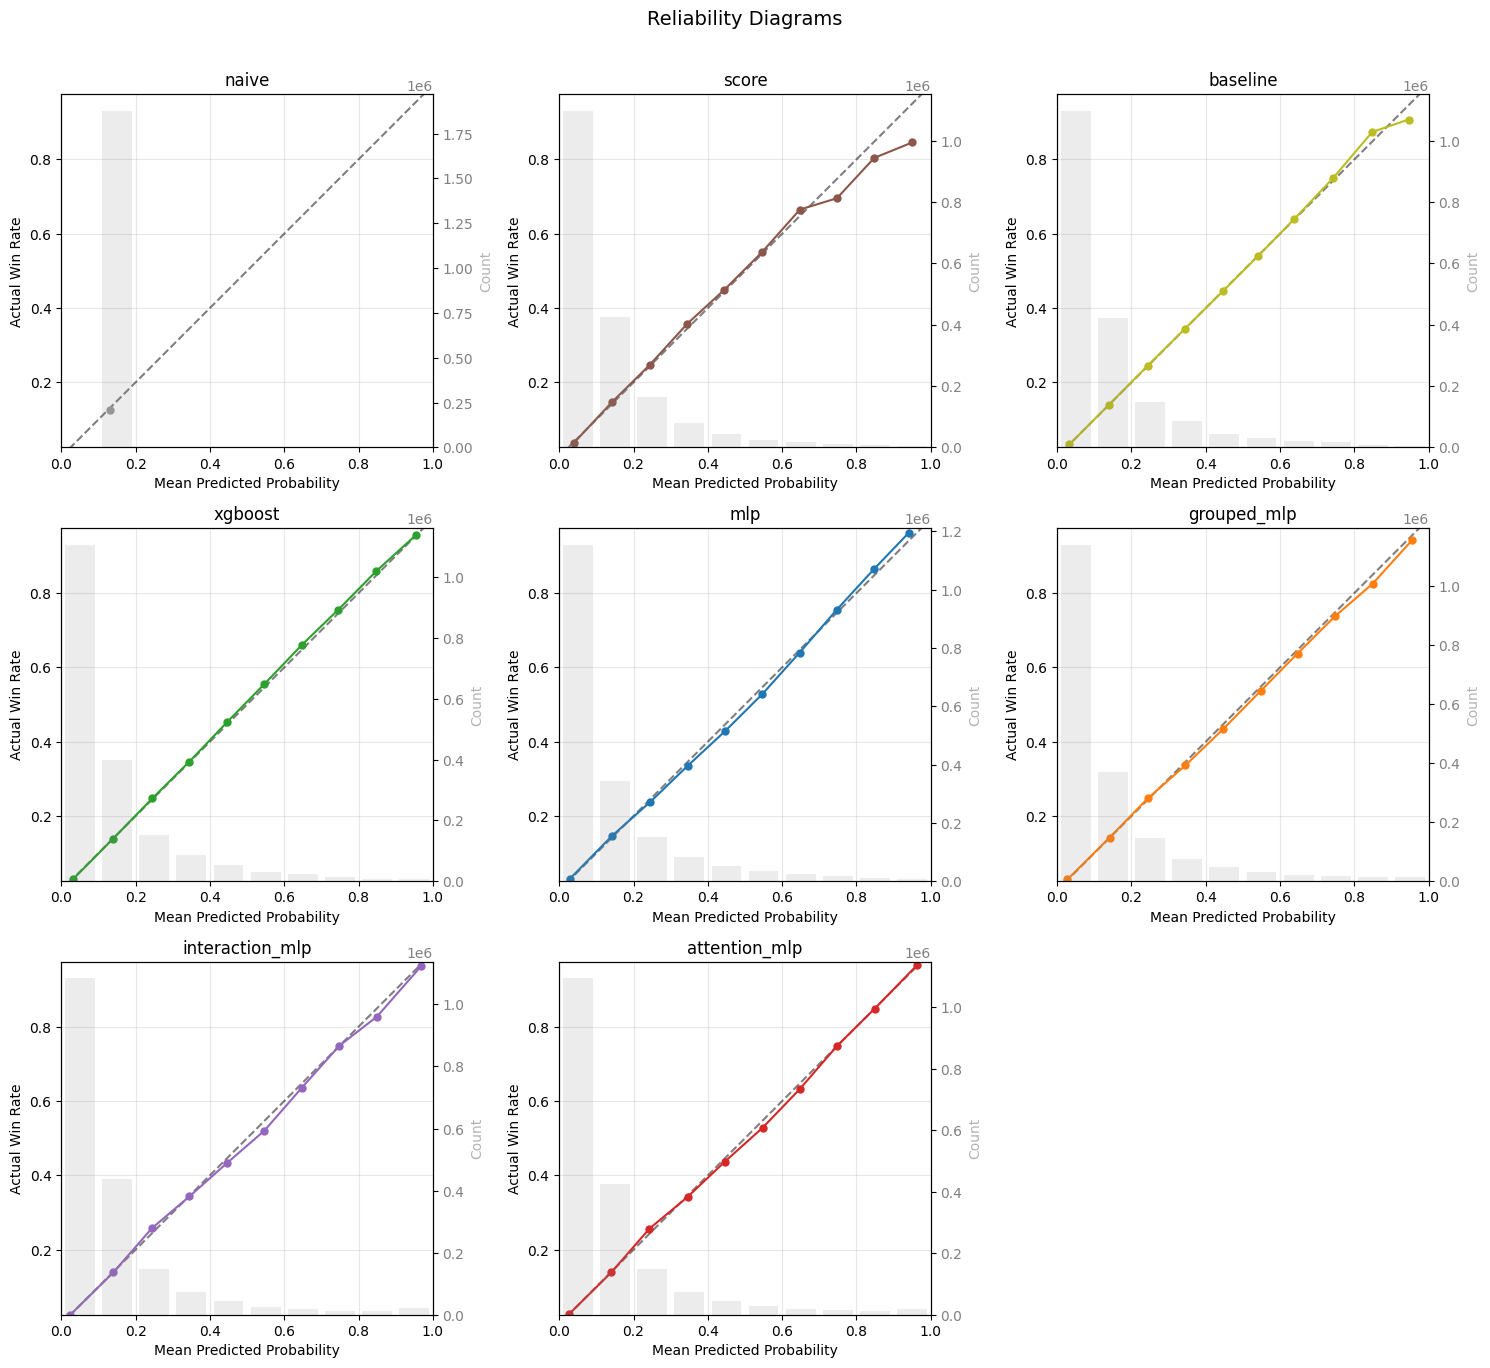

In [2]:
n_bins = 10
n_models = len(models)
cols = min(3, n_models)
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), squeeze=False)

for idx, name in enumerate(MODEL_ORDER):
    if name not in models:
        continue
    df = models[name]
    ax = axes[idx // cols][idx % cols]
    pred = df["predicted_win_probability"].values
    true = df["is_winner"].values

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(pred, bin_edges[1:-1])

    mean_pred = np.array([pred[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan for i in range(n_bins)])
    mean_true = np.array([true[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan for i in range(n_bins)])
    counts = np.array([(bin_indices == i).sum() for i in range(n_bins)])

    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect")
    ax.plot(mean_pred, mean_true, "o-", markersize=5, label=name, color=MODEL_COLORS[name])
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Actual Win Rate")
    ax.set_title(f"{name}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)

    # Histogram overlay
    ax2 = ax.twinx()
    ax2.bar(bin_centers, counts, width=0.08, alpha=0.15, color="gray")
    ax2.set_ylabel("Count", color="gray", alpha=0.6)
    ax2.tick_params(axis="y", labelcolor="gray")

# Hide empty subplots
for idx in range(n_models, rows * cols):
    axes[idx // cols][idx % cols].set_visible(False)

fig.suptitle("Reliability Diagrams", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 1b. Winner vs Loser Prediction Distributions
KDE plots of predicted win probability, split by actual outcome.  
Good discrimination = well-separated peaks.

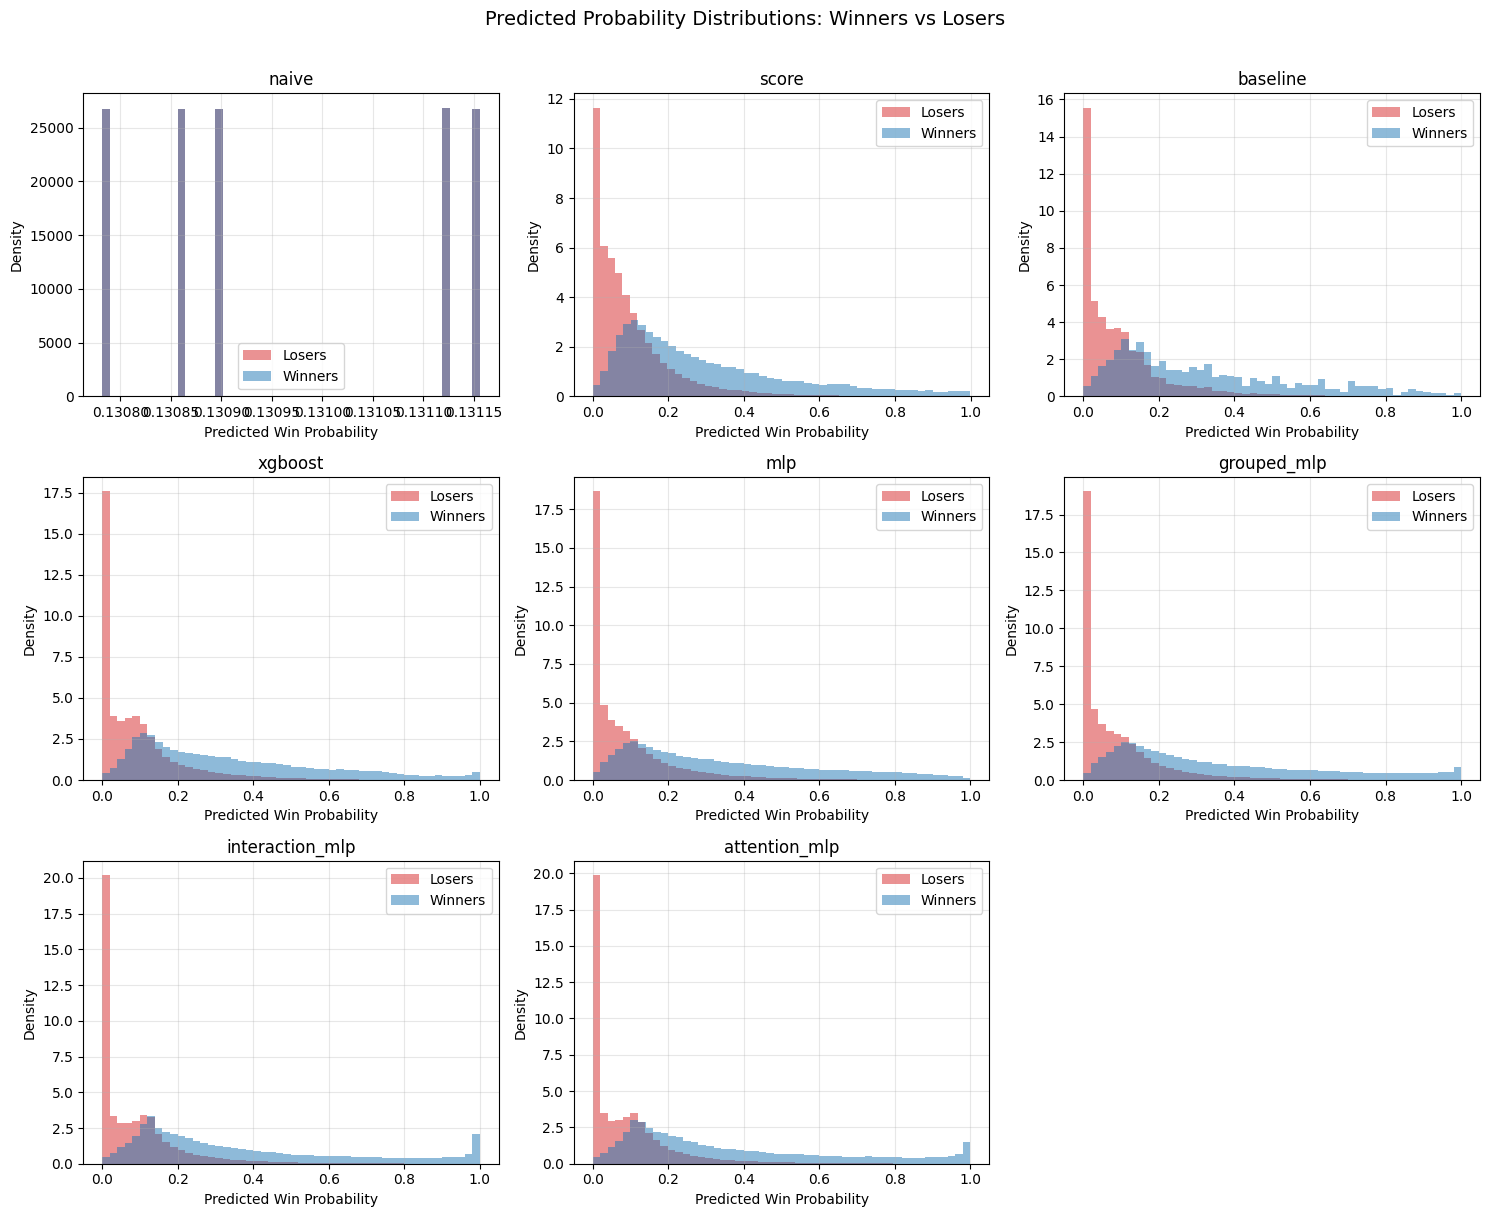

In [3]:
n_models = len(models)
cols = min(3, n_models)
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

for idx, (name, df) in enumerate(models.items()):
    ax = axes[idx // cols][idx % cols]
    winners = df[df["is_winner"] == 1]["predicted_win_probability"]
    losers = df[df["is_winner"] == 0]["predicted_win_probability"]

    ax.hist(losers, bins=50, density=True, alpha=0.5, label="Losers", color="tab:red")
    ax.hist(winners, bins=50, density=True, alpha=0.5, label="Winners", color="tab:blue")
    ax.set_xlabel("Predicted Win Probability")
    ax.set_ylabel("Density")
    ax.set_title(f"{name}")
    ax.legend()
    ax.grid(True, alpha=0.3)

for idx in range(n_models, rows * cols):
    axes[idx // cols][idx % cols].set_visible(False)

fig.suptitle("Predicted Probability Distributions: Winners vs Losers", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 1c. Confidence Evolution by Game Phase
Mean absolute deviation from the uniform prior (0.25) as a proxy for model confidence.  
Split by eventual winner/loser to see when models start distinguishing them.

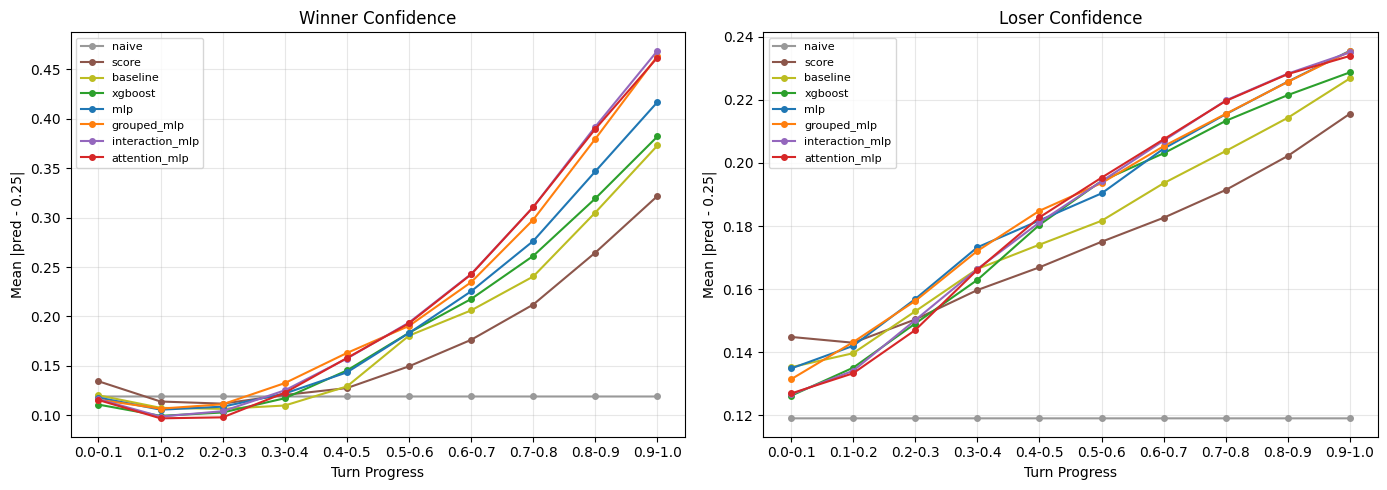

In [4]:
bins = np.arange(0, 1.1, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name in MODEL_ORDER:
    if name not in models:
        continue
    df = models[name].copy()
    color = MODEL_COLORS[name]
    df["confidence"] = (df["predicted_win_probability"] - 0.25).abs()
    df["bin"] = pd.cut(df["turn_progress"], bins=bins, labels=labels, right=False)

    # Winner confidence
    winners = df[df["is_winner"] == 1].groupby("bin", observed=True)["confidence"].mean()
    axes[0].plot(winners.index, winners.values, marker="o", label=name, markersize=4, color=color)

    # Loser confidence
    losers = df[df["is_winner"] == 0].groupby("bin", observed=True)["confidence"].mean()
    axes[1].plot(losers.index, losers.values, marker="o", label=name, markersize=4, color=color)

axes[0].set_xlabel("Turn Progress")
axes[0].set_ylabel("Mean |pred - 0.25|")
axes[0].set_title("Winner Confidence")
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel("Turn Progress")
axes[1].set_ylabel("Mean |pred - 0.25|")
axes[1].set_title("Loser Confidence")
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()